# Trial Notebook

Here, we have written the code to load the dataset and also to test the dagmm architecture. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [3]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

train_dataset = datasets.ImageFolder("../split_anomaly_dataset/train", transform=transform)
test_dataset = datasets.ImageFolder("../split_anomaly_dataset/test", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

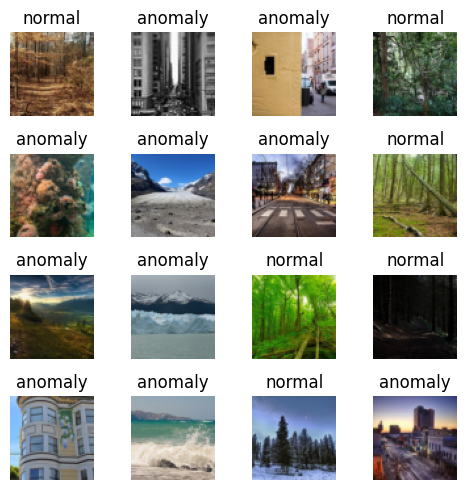

In [4]:
class_names = train_dataset.classes  # ['anomaly', 'normal']

data_iter = iter(train_loader)
images, labels = next(data_iter)

plt.figure(figsize=(5, 5))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    img = images[i].permute(1, 2, 0)
    label = class_names[labels[i]]
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

plt.tight_layout()
plt.show()


here, we have chosen forest as normal, and all other images as anomaly.

In [5]:
print(img.shape)

torch.Size([64, 64, 3])


In [7]:
import model, importlib, torch
importlib.reload(model)
print("Loaded model.py from:", model.__file__)

m = model.DAGMM(input_dim=30, latent_dim=10, n_gmm_components=5).eval()
print("Compression sub‑net:", m.compression)
x = torch.randn(4, 30)
with torch.no_grad():
    z = m.compression(x)
print("z.shape should be (4,10):", z.shape)


Loaded model.py from: /Users/aryan/Desktop/Academics /Semester 4/Data science/Project/gmm_anomalydetection/cnn_arch/model.py
Compression sub‑net: CompressionNetwork(
  (encoder): Sequential(
    (0): Linear(in_features=30, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=10, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): Tanh()
    (4): Linear(in_features=128, out_features=30, bias=True)
  )
  (_reconstruction_loss): MSELoss()
)
z.shape should be (4,10): torch.Size([4, 30])


Epoch 01/15 — loss: 3.8137
Epoch 02/15 — loss: 3.0319
Epoch 03/15 — loss: 2.4763
Epoch 04/15 — loss: 2.0448
Epoch 05/15 — loss: 1.6893
Epoch 06/15 — loss: 1.3842
Epoch 07/15 — loss: 1.1403
Epoch 08/15 — loss: 0.9390
Epoch 09/15 — loss: 0.7349
Epoch 10/15 — loss: 0.4640
Epoch 11/15 — loss: 0.1798
Epoch 12/15 — loss: -0.1497
Epoch 13/15 — loss: -0.3145
Epoch 14/15 — loss: -0.5505
Epoch 15/15 — loss: -0.8520


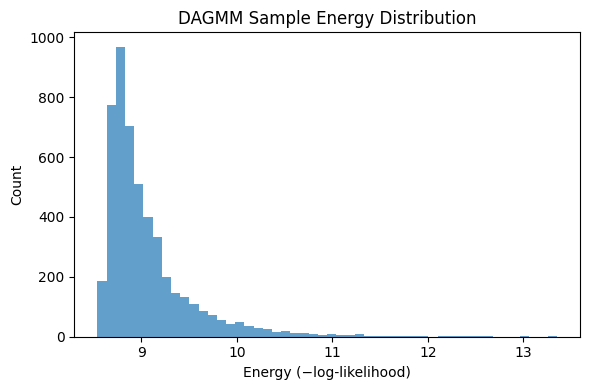

In [10]:
# %% [markdown]
# # DAGMM Training & Scoring Example

# %% [code]
# 1. Imports
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

from model import DAGMM

# %% [code]
# 2. Prepare your data
# Replace this with your real feature matrix of shape [n_samples, n_features]
import numpy as np
n_samples, n_features = 5000, 30
X = np.random.randn(n_samples, n_features).astype(np.float32)

# Wrap in a DataLoader
dataset = TensorDataset(torch.from_numpy(X))
loader  = DataLoader(dataset, batch_size=128, shuffle=True, drop_last=True)

# %% [code]
# 3. Instantiate model + optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DAGMM(
    input_dim       = n_features,
    latent_dim      = 10,
    n_gmm_components= 5,
    comp_kwargs     = {'hidden_dims': [64, 32], 'activation': torch.nn.Tanh},
    est_kwargs      = {'hidden_dims': [32],       'activation': torch.nn.ReLU, 'dropout': 0.3},
    device          = device
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# %% [code]
# 4. Training loop
n_epochs = 15
for epoch in range(1, n_epochs+1):
    model.train()
    running_loss = 0.0

    for (x_batch,) in loader:
        x_batch = x_batch.to(device)
        outputs = model(x_batch)
        loss    = model.loss_function(x_batch, outputs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * x_batch.size(0)

    avg_loss = running_loss / (len(loader) * loader.batch_size)
    print(f"Epoch {epoch:02d}/{n_epochs} — loss: {avg_loss:.4f}")

# %% [code]
# 5. Compute per-sample energy scores
model.eval()
all_energies = []
with torch.no_grad():
    for (x_batch,) in loader:
        x_batch = x_batch.to(device)
        out     = model(x_batch)
        all_energies.append(out['energy'].cpu())
all_energies = torch.cat(all_energies)

# %% [code]
# 6. Plot energy distribution
plt.figure(figsize=(6,4))
plt.hist(all_energies.numpy(), bins=50, alpha=0.7)
plt.title("DAGMM Sample Energy Distribution")
plt.xlabel("Energy (−log‑likelihood)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# %% [markdown]
# ## Next Steps
# - **Inject anomalies**: replace some rows in `X` with out‑of‑distribution data and observe elevated energies.  
# - **Thresholding**: pick a percentile (e.g. 95th) on `all_energies` as your anomaly cutoff.  
# - **Hyperparam tuning**: adjust `latent_dim`, hidden sizes, `n_gmm_components`, learning rate, etc.


# Rough

In [10]:
eye = I_D.unsqueeze(0)            # shape (1,D,D)
cov_raw @ cov_raw.transpose(-1,-2) + 1e-6 * eye

NameError: name 'I_D' is not defined